In [3]:
import warnings

warnings.filterwarnings('ignore')

# TASK 1 Car Price Prediction

## Some Imports

In [4]:
import pandas as pd
import numpy as np
import warnings
import joblib
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Load the The Data set

In [ ]:
df = pd.read_csv("car_data.csv")
df.head()

,Make,Model,Version,Price,Make_Year,CC,Assembly,Mileage,Registered City,Transmission
0,Honda,Insight,NaN,7400000.0,2019,1500,Imported,2000,Un-Registered,Automatic
1,Mitsubishi,Minica,Black Minica,1065000.0,2019,660,Imported,68000,Lahore,Automatic
2,Audi,A6,1.8 TFSI Business Class Edition,9300000.0,2015,1800,Local,70000,Lahore,Automatic
3,Toyota,Aqua,G,2375000.0,2014,1500,Imported,99900,Islamabad,Automatic
4,Honda,City,1.3 i-VTEC,2600000.0,2017,1300,Local,55000,Islamabad,Manual


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80572 entries, 0 to 80571
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Make             80572 non-null  object
 1   Model            80572 non-null  object
 2   Version          73800 non-null  object
 3   Price            80572 non-null  object
 4   Make_Year        80572 non-null  int64 
 5   CC               80572 non-null  int64 
 6   Assembly         80572 non-null  object
 7   Mileage          80572 non-null  int64 
 8   Registered City  80572 non-null  object
 9   Transmission     80572 non-null  object
dtypes: int64(3), object(7)
memory usage: 6.1+ MB


In [ ]:
df.describe()

,Make_Year,CC,Mileage
count,80572.000000,80572.000000,80572.000000
mean,2011.724209,1404.083267,85653.660080
std,6.953399,684.458171,82241.870901
min,1990.000000,1.000000,1.000000
25%,2007.000000,1000.000000,36500.000000
50%,2013.000000,1300.000000,73000.000000
75%,2017.000000,1600.000000,110520.000000
max,2021.000000,10000.000000,999999.000000


## Count No of Duplicates in the dataset.

In [ ]:
duplicates = df.duplicated()
duplicate_count = duplicates.sum()
print(f"The Dataset Contatins following no Of Duplicates {duplicate_count}" )

The Dataset Contatins following no Of Duplicates 1684


## For Deleteing The Duplicate Records

In [ ]:
data = df.copy()
#data = data.drop_duplicates()
#print(f"Deleted {df.shape[0]-data.shape[0]} duplicated rows")

## Handling Missing Values
### A custom Function to drop or to fill

# Some Needed Preprocessing

1.   Replace non-numeric 'Price' entries with NaN
2.   Drop rows where 'Price' is NaN
3.   Convert 'Price' column to float


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80572 entries, 0 to 80571
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Make             80572 non-null  object
 1   Model            80572 non-null  object
 2   Version          73800 non-null  object
 3   Price            80572 non-null  object
 4   Make_Year        80572 non-null  int64 
 5   CC               80572 non-null  int64 
 6   Assembly         80572 non-null  object
 7   Mileage          80572 non-null  int64 
 8   Registered City  80572 non-null  object
 9   Transmission     80572 non-null  object
dtypes: int64(3), object(7)
memory usage: 6.1+ MB


In [ ]:
data['Price'] = data['Price'].replace('[\$,]', '', regex=True).replace('Call for price', np.nan)
data = data.dropna(subset=['Price'])
data['Price'] = data['Price'].astype(float)

<ipython-input-181-7890ed6f4dea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price'] = data['Price'].astype(float)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79363 entries, 0 to 80571
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Make             79363 non-null  object 
 1   Model            79363 non-null  object 
 2   Version          72655 non-null  object 
 3   Price            79363 non-null  float64
 4   Make_Year        79363 non-null  int64  
 5   CC               79363 non-null  int64  
 6   Assembly         79363 non-null  object 
 7   Mileage          79363 non-null  int64  
 8   Registered City  79363 non-null  object 
 9   Transmission     79363 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 6.7+ MB


## A Function To handle Null Values In the dataset

In [ ]:
def handle_nulls(df, method='fill'):

    null_counts = df.isnull().sum()
    total_nulls = null_counts.sum()

    if method == 'drop':
      print("===================> drop method used Deleting rows containing null values.")
      df_cleaned = df.dropna()
      return null_counts, total_nulls, df_cleaned

    elif method == "fill":
      print("===================> fill method used filling rows containing null values.")
      for column in df.columns:
          if df[column].dtype == 'object':
              mode_value = df[column].mode()[0]
              df[column].fillna(mode_value, inplace=True)
          else:
              mean_value = df[column].mean()
              df[column].fillna(mean_value, inplace=True)

      return total_nulls, null_counts, df

    else:
      raise ValueError("Methods Must be 'drop' or 'fill'. ")


df = pd.DataFrame(data)
df = df.drop(columns=["Version"])
total_nulls, null_counts, df_cleaned = handle_nulls(df, method="fill")
print("Total number of nulls:")
print(total_nulls)
print("Null counts per column:")
print(null_counts)
print("DataFrame after handling nulls:")
print(df_cleaned)

===================> fill method used filling rows containing null values.
Total number of nulls:
0
Null counts per column:
Make               0
Model              0
Price              0
Make_Year          0
CC                 0
Assembly           0
Mileage            0
Registered City    0
Transmission       0
dtype: int64
DataFrame after handling nulls:
             Make    Model      Price  Make_Year    CC  Assembly  Mileage  \
0           Honda  Insight  7400000.0       2019  1500  Imported     2000   
1      Mitsubishi   Minica  1065000.0       2019   660  Imported    68000   
2            Audi       A6  9300000.0       2015  1800     Local    70000   
3          Toyota     Aqua  2375000.0       2014  1500  Imported    99900   
4           Honda     City  2600000.0       2017  1300     Local    55000   
...           ...      ...        ...        ...   ...       ...      ...   
80567      Suzuki    Bolan   750000.0       2015   800     Local    98000   
80568      Suzuki     Alto

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79363 entries, 0 to 80571
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Make             79363 non-null  object 
 1   Model            79363 non-null  object 
 2   Price            79363 non-null  float64
 3   Make_Year        79363 non-null  int64  
 4   CC               79363 non-null  int64  
 5   Assembly         79363 non-null  object 
 6   Mileage          79363 non-null  int64  
 7   Registered City  79363 non-null  object 
 8   Transmission     79363 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.1+ MB


In [ ]:
df_cleaned["Price"]

0        7400000.0
1        1065000.0
2        9300000.0
3        2375000.0
4        2600000.0
           ...    
80567     750000.0
80568    1480000.0
80569    2700000.0
80570     600000.0
80571    2620000.0
Name: Price, Length: 79363, dtype: float64

## Visualizing to have a Better Understanding of the dataset

<Figure size 1000x600 with 0 Axes>

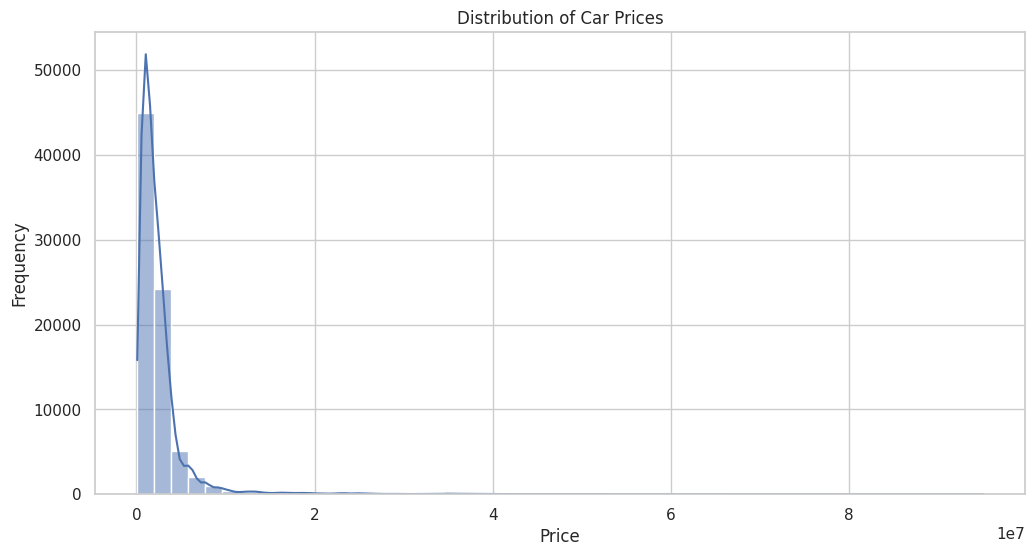

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['Price'].astype(float), bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2. Count of Cars by Make

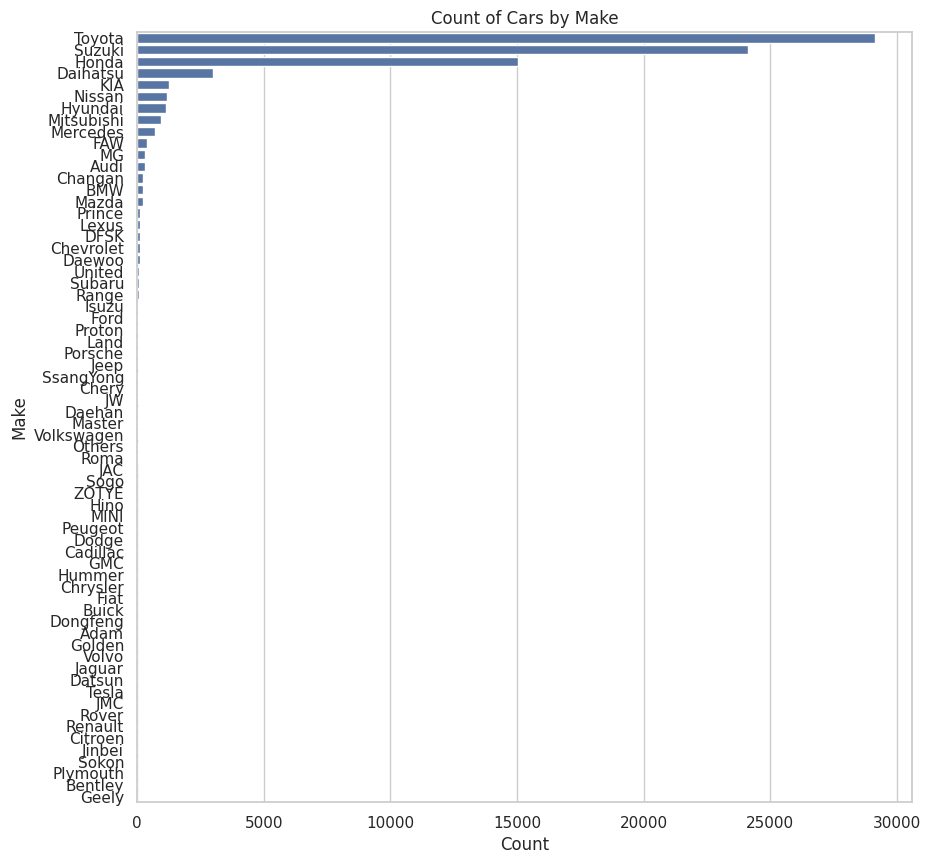

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(y='Make', data=df_cleaned, order=df_cleaned['Make'].value_counts().index)
plt.title('Count of Cars by Make')
plt.xlabel('Count')
plt.ylabel('Make')
plt.show()

# 3. Average Price by Make

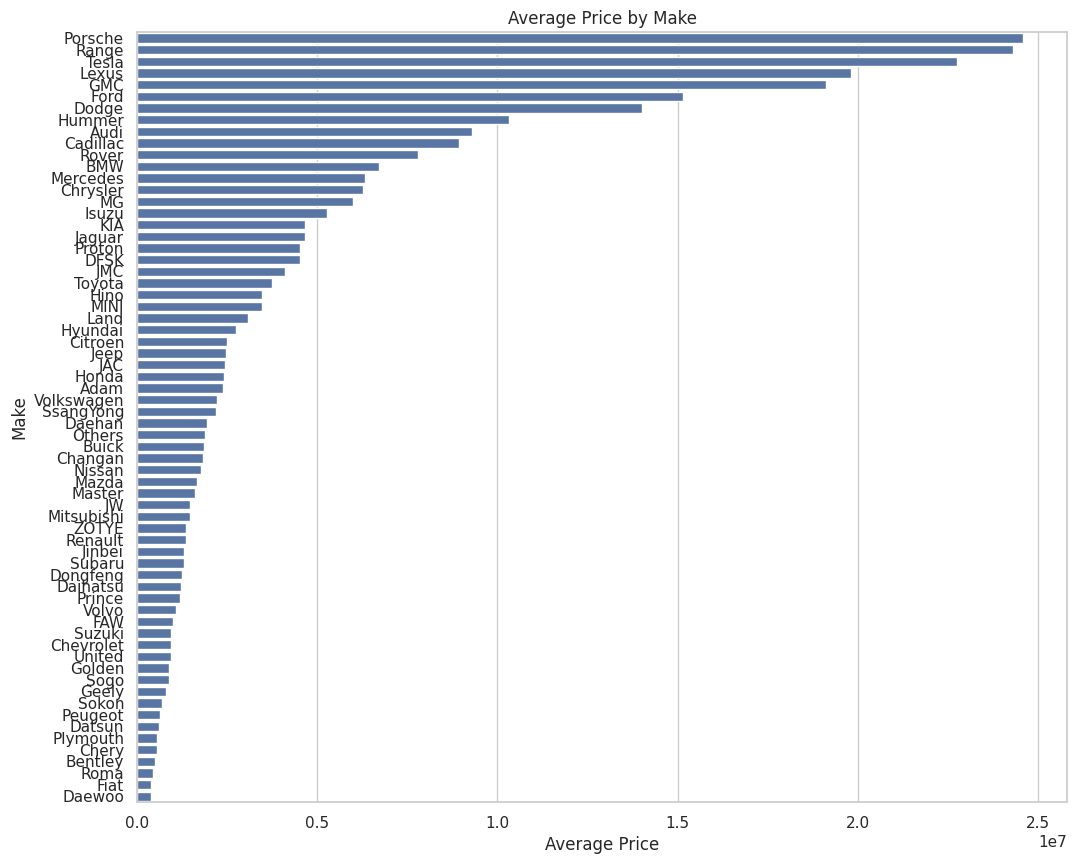

In [ ]:
plt.figure(figsize=(12, 10))
average_price_by_make = df_cleaned.groupby('Make')['Price'].mean().sort_values(ascending=False)
sns.barplot(x=average_price_by_make, y=average_price_by_make.index)
plt.title('Average Price by Make')
plt.xlabel('Average Price')
plt.ylabel('Make')
plt.show()

# 4. Distribution of Car Ages

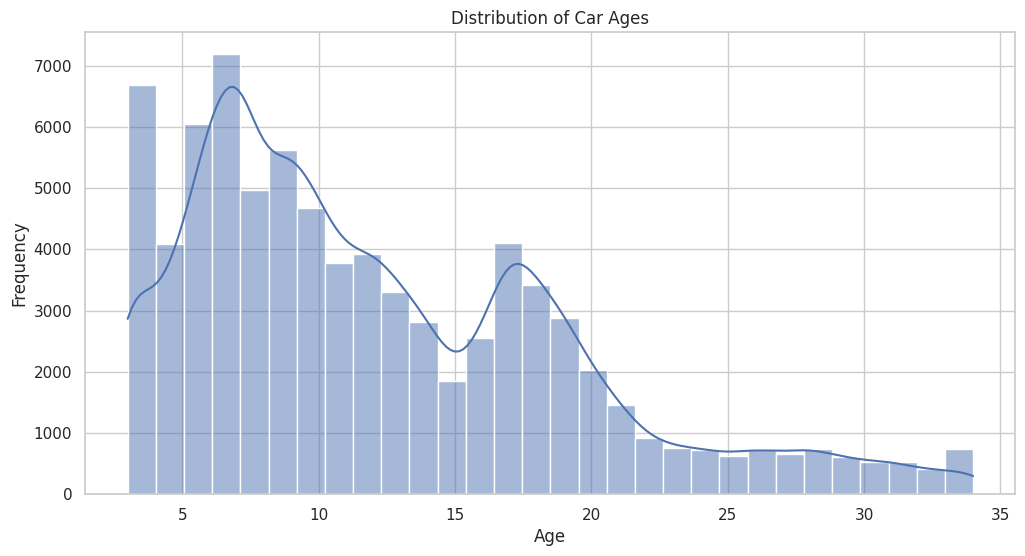

In [ ]:
current_year = 2024
df_cleaned['Car_Age'] = current_year - df_cleaned['Make_Year']

plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['Car_Age'], bins=30, kde=True)
plt.title('Distribution of Car Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


# 5. Mileage vs. Price

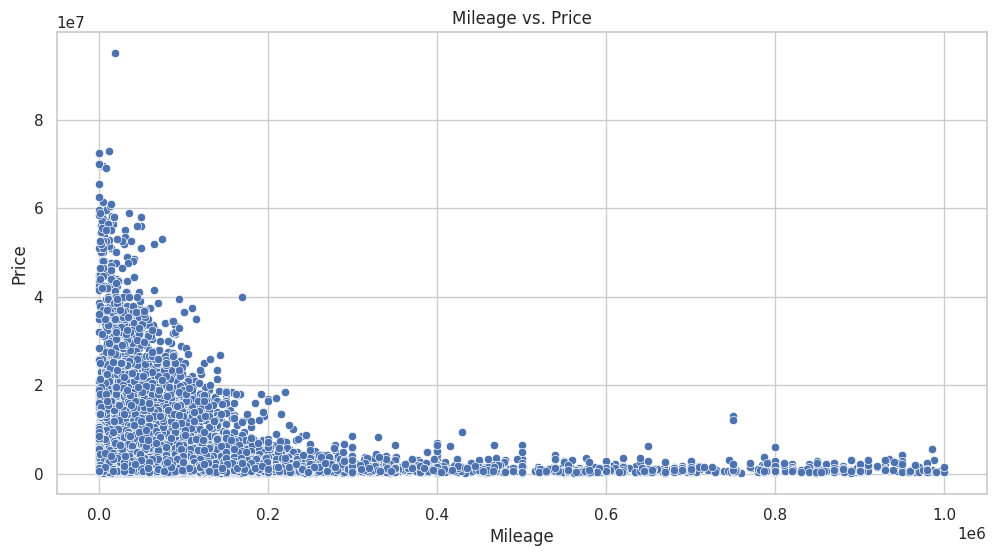

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Mileage', y='Price', data=df_cleaned)
plt.title('Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()


# 6. Transmission Type Distribution

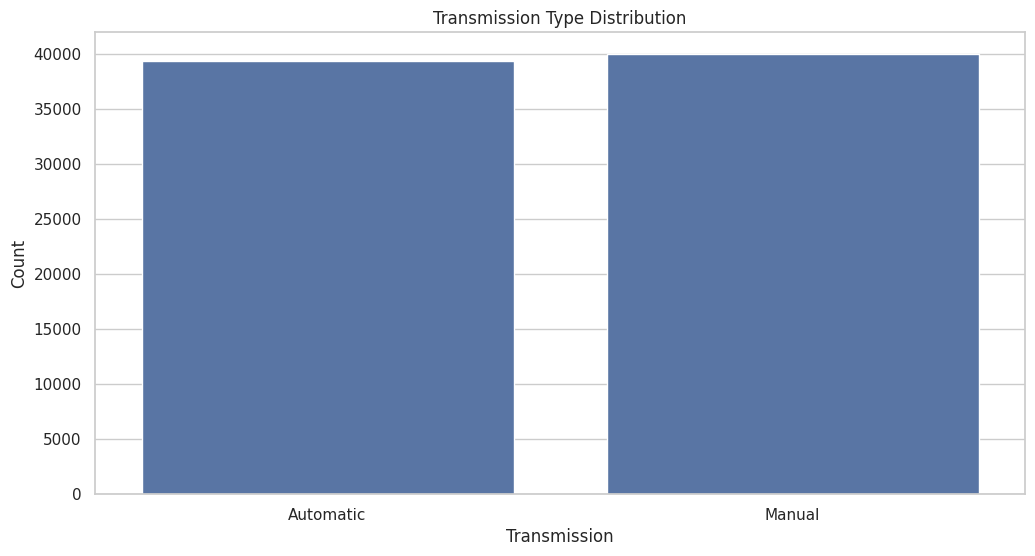

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Transmission', data=df_cleaned)
plt.title('Transmission Type Distribution')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.show()


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79363 entries, 0 to 80571
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Make             79363 non-null  object 
 1   Model            79363 non-null  object 
 2   Price            79363 non-null  float64
 3   Make_Year        79363 non-null  int64  
 4   CC               79363 non-null  int64  
 5   Assembly         79363 non-null  object 
 6   Mileage          79363 non-null  int64  
 7   Registered City  79363 non-null  object 
 8   Transmission     79363 non-null  object 
 9   Car_Age          79363 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 6.7+ MB


# Lets See which of the Features are Contributing more TOwards the Price

In [ ]:
target_column = "Price"


#df_cleaned = df_cleaned.drop(columns=["Make"])
#df_cleaned = df_cleaned.drop(columns=["Make_Year"])
#df_cleaned = df_cleaned.drop(columns=["Assembly"])
#df_cleaned = df_cleaned.drop(columns=["Registered City"])

X = df_cleaned.drop(columns=[target_column])
y = df_cleaned[target_column]

num_selected_features = df.shape[1] - 1

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79363 entries, 0 to 80571
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Make             79363 non-null  object
 1   Model            79363 non-null  object
 2   CC               79363 non-null  int64 
 3   Assembly         79363 non-null  object
 4   Mileage          79363 non-null  int64 
 5   Registered City  79363 non-null  object
 6   Transmission     79363 non-null  object
 7   Car_Age          79363 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 5.4+ MB


## Lets see Wich of these Models Perform Better.


1.   DecisionTreeRegressor
2.   LinearRegression
3.   ElasticNet
4.   RandomForestRegressor
5.   KNeighborsRegressor
6.   XGBRegressor



### A function Which uses Ensemble learning to Train Multiple Models and See Which OF the are can be a better fit for this dataset.

In [ ]:
def supervised_learning(X,Y,num_selected_features):

    predictions_list = list()
    scores = list()
    models_ = list()

    _id = "1"
    y_encoded = y

    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_features = X.select_dtypes(include=['object']).columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    feature_selector = SelectKBest(score_func=f_regression, k=num_selected_features)
    models = [
        ('DecisionTreeRegressor', DecisionTreeRegressor()),
        ('LinearRegression', LinearRegression()),
        ('ElasticNet', ElasticNet()),
        ('RandomForestRegressor', RandomForestRegressor()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('XGBRegressor', XGBRegressor())
    ]
    # print("Regression===================")

    best_model_name = None
    best_metric = float('-inf')
    accuracy = None
    precision = None
    recall = None
    best_model = None

    for model_name, model in models:
        print("Training ================>", model_name)

        models_.append(model_name)

        model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('selector', feature_selector),
                                         ('model', model)])

        X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_test)


        predictions_list.append((model_name, y_pred))


        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        metric = r2
        print(metric)

        scores.append(metric)


        if (y.dtypes != 'object' and metric > best_metric):
            best_metric = metric
            best_model_name = model_name
            best_model = model_pipeline

        if best_model is not None:
            directory_path = "User_models"
            os.makedirs(directory_path, exist_ok=True)
            joblib.dump(best_model, os.path.join(directory_path, f"{_id}_Best_Model.pkl"))

    return best_model_name, best_metric, scores, models_, predictions_list, y_test


model_name, best_metric, scores, models, preds, y_test= supervised_learning(X,y,num_selected_features)


Training ================> DecisionTreeRegressor
0.887406462432287
Training ================> LinearRegression
0.6065681821655007
Training ================> ElasticNet
0.43778778301080934
Training ================> RandomForestRegressor
0.8890404702358267
Training ================> KNeighborsRegressor
0.8855181481466031
Training ================> XGBRegressor
0.882414167802321


## Lets make a New Data Frame for Predictions of Every model And the Actual Values of the testSet

In [ ]:
y_test_array = y_test.values.flatten()  # Convert y_test to a numpy array
preds.append(("Actual", y_test_array))
preds

[('DecisionTreeRegressor',
  array([1068118.27956989, 2438651.98237885, 1199151.2605042 , ...,
         3862538.58024691, 1480601.0230179 ,  780809.73451327])),
 ('LinearRegression',
  array([ 240422.70078957, 2601591.86571497,  690540.64451094, ...,
         3944926.90949768, 1089670.57193209, 1149497.7854816 ])),
 ('ElasticNet',
  array([ 688199.44216366, 2882691.26536654, 1121258.43488288, ...,
         4163278.75623969, 1376010.18939545, 1126354.48134399])),
 ('RandomForestRegressor',
  array([1065642.41263046, 2435938.75478028, 1198595.3276933 , ...,
         3869993.78807648, 1481617.5186226 ,  780989.88165263])),
 ('KNeighborsRegressor',
  array([1000000., 2458000., 1100000., ..., 3595000., 1513000.,  841000.])),
 ('XGBRegressor',
  array([1055834.8 , 2482636.  , 1252684.8 , ..., 3863755.2 , 1467901.5 ,
          778024.94], dtype=float32)),
 ('Actual',
  array([1080000., 2450000., 1200000., ..., 5300000., 1000000.,  835000.]))]

## Lets Visualize the Results

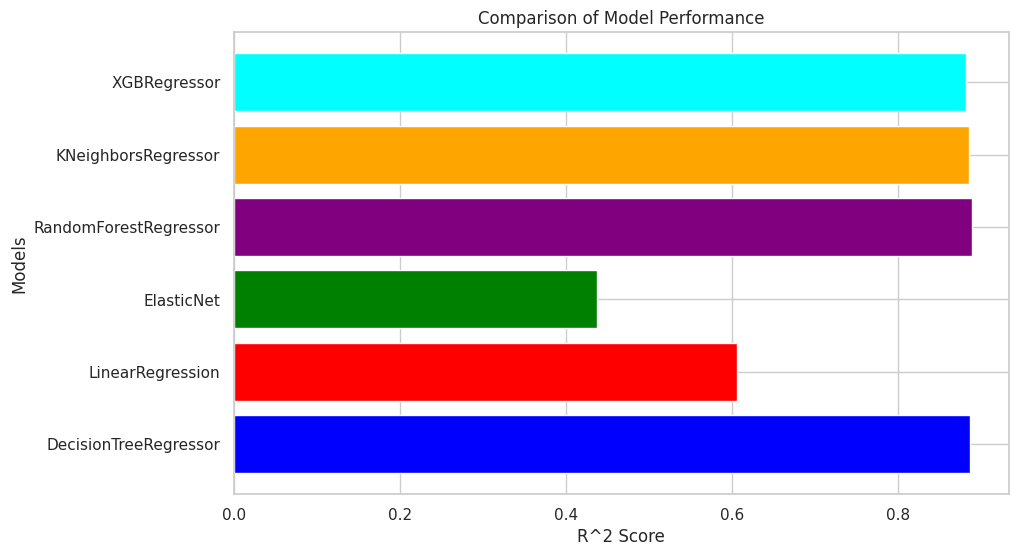

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(models, scores, color=['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
plt.xlabel('R^2 Score')
plt.ylabel('Models')
plt.title('Comparison of Model Performance')
plt.show()

## We See that These Models did Quite Well.


1.   DecisionTreeRegressor
2.   RandomForestRegressor
4.   XGBoostRegressor


In [ ]:
print(f"And the best Performing model is Random Forest with an r2 Score of {max(scores)}")



And the best Performing model is Random Forest with an r2 Score of 0.8890404702358267


# By Performance We see RandomForest Performs Well on this Dataset so lets Improve the Model Further for Better Results

## Now that we have a better Understanding of the dataset and models lets Dive in for more Improvment on the way

In [5]:
file_path = 'car_data.csv'
data = pd.read_csv(file_path)

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

binary_features = ['Assembly', 'Transmission']

label_encoders = {}
for feature in binary_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

categorical_features = ['Make', 'Model', 'Version', 'Registered City']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)


In [7]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['Make_Year', 'CC', 'Mileage']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [8]:
from datetime import datetime

current_year = datetime.now().year
data['Car_Age'] = current_year - data['Make_Year']
data.drop(columns=['Make_Year'], inplace=True)


In [9]:
data['Price'] = data['Price'].replace('[\$,]', '', regex=True).replace('Call for price', np.nan)
data = data.dropna(subset=['Price'])
data['Price'] = data['Price'].astype(float)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = data.drop(columns=['Price'])
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [11]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Absolute Error: 89142750977789.06
Mean Squared Error: 3.7504893314859e+31
R² Score: -2.5097204275319593e+18


## Lets Get into it Improving Randomforest our best Compitator

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

print("Training model...")
rf.fit(X_train, y_train)
print("Model training complete.")

# Predict and evaluate
print("Predicting...")
y_pred_rf = rf.predict(X_test)
print("Prediction complete.")

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Absolute Error (RF): {mae_rf}')
print(f'Mean Squared Error (RF): {mse_rf}')
print(f'R² Score (RF): {r2_rf}')

Training model...
Model training complete.
Predicting...
Prediction complete.
Mean Absolute Error (RF): 233565.97635344308
Mean Squared Error (RF): 789116635158.6364
R² Score (RF): 0.9471945667906145


## So Here We See We Have an improved Version of that model with an improved Evaluation Results.

# To Save the Model

In [24]:
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']